In [1]:
import pandas as pd
df = pd.read_csv(r"final_mapped_categories2.csv")
df.head(10)

,Recipe URL,Recipe name,Preparation time,Servings,List of ingredients,List of instructions,Category,Region/Cuisine,Calories_Per_Serving,Broad_Category
0,https://www.food.com/recipe/cheesy-grits-casse...,cheesy grits casserole,65.0,6.0,4cupswater 1teaspoonsalt 1cupquickcooking grit...,heat water and salt to boiling gradually add g...,oven,Unknown,493.0,Bread
1,https://www.food.com/recipe/crock-pot-beer-bra...,crock pot beer brats,440.0,4.0,8bratwursts 2tablespoonsolive oil 2garlic clov...,heat oil and garlic in a large skillet add bra...,pork,Unknown,493.0,Meat/Poultry
2,https://www.food.com/recipe/banana-bread-with-...,banana bread with coconut milk,40.0,10.0,4ripe mashedbananas 712ounces canscoconut milk...,mix wet ingredients and dry ingredients mixtur...,quick breads,Unknown,493.0,Bread
3,https://www.food.com/recipe/pasta-salad-suprem...,pasta salad supreme,25.0,6.0,16ouncesrotini pastaor 16 ouncesshell pastasom...,cook pasta rinse under cold water and drain we...,vegetable,Unknown,493.0,Vegetable
4,https://www.food.com/recipe/bread-machine-monk...,bread machine monkey pull aparts,70.0,11.0,112teaspoonsactive dry yeast 114cupsbread flou...,add ingredients to your bread maker according ...,breads,Unknown,493.0,Bread
5,https://www.food.com/recipe/low-carb-pizza-zuc...,low carb pizza zucchini crust,75.0,6.0,4mediumzucchini grated 2eggs 114 ounce jar piz...,preheat oven to 375 degrees spray a pizza pan ...,vegetable,Unknown,493.0,Vegetable
6,https://www.food.com/recipe/hamburger-crust-pi...,hamburgercrust pizza,25.0,12.0,1lblean ground beef 1garlic clove minced 18 ou...,mix the beef and the garlic and press into a 1...,onions,Unknown,493.0,Vegetable
7,https://www.food.com/recipe/crock-pot-cheesy-s...,crock pot cheesy spinach,368.0,9.0,210 ounce boxesfrozen chopped spinach thawed a...,spray your crock pot with pam or grease the in...,spinach,Unknown,493.0,Vegetable
8,https://www.food.com/recipe/chilis-chicken-faj...,jalapeno macaroni cheese casserole,45.0,12.0,14cupbutter 3jalapenos minced and seeded 1teas...,preheat oven to 350 degrees melt butter in med...,cheese,Unknown,493.0,Salad
9,https://www.food.com/recipe/easy-delicious-slo...,easy delicious slow cooker roast beef,485.0,4.0,3 4lbsbeef roastany cut 3bay leaves 1teaspoonb...,put roast beef into slow cooker cover with sou...,roast beef,Unknown,493.0,Meat/Poultry


In [2]:
import pandas as pd
import re
import numpy as np
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


Read, Clean & Merge

In [3]:
df = pd.read_csv("final_mapped_categories2.csv")
df.fillna("Unknown", inplace=True)
df["text"] = df["Recipe name"].astype(str) + " " + df["List of ingredients"].astype(str) + " " + df["List of instructions"].astype(str)
df[["text", "Preparation time", "Region/Cuisine", "Broad_Category"]].head()


,text,Preparation time,Region/Cuisine,Broad_Category
0,cheesy grits casserole 4cupswater 1teaspoonsal...,65.0,Unknown,Bread
1,crock pot beer brats 8bratwursts 2tablespoonso...,440.0,Unknown,Meat/Poultry
2,banana bread with coconut milk 4ripe mashedban...,40.0,Unknown,Bread
3,pasta salad supreme 16ouncesrotini pastaor 16 ...,25.0,Unknown,Vegetable
4,bread machine monkey pull aparts 112teaspoonsa...,70.0,Unknown,Bread


Tokenization & Training

In [4]:
def simple_tokenize(text):
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text.lower().split()

tagged_data = [
    TaggedDocument(words=simple_tokenize(row["text"]), tags=[i])
    for i, row in df.iterrows()
]

d2v_model = Doc2Vec(vector_size=50, window=5, min_count=2, workers=4, epochs=20)
d2v_model.build_vocab(tagged_data)
d2v_model.train(tagged_data, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)


X and Y: Training and Target Columns

In [5]:
text_vectors = np.array([d2v_model.infer_vector(doc.words) for doc in tagged_data])
numeric_features = df[["Preparation time", "Servings", "Calories_Per_Serving"]].astype(float)

scaler = StandardScaler()
numeric_scaled = scaler.fit_transform(numeric_features)

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
region_encoded = encoder.fit_transform(df[["Region/Cuisine"]])

X = np.hstack([text_vectors, numeric_scaled, region_encoded])
y = df["Broad_Category"]


Train/Test Split & Comparision Models

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM (Linear Kernel)": SVC(kernel='linear'),
    "Naive Bayes": GaussianNB(),
    "KNN (k=5)": KNeighborsClassifier(n_neighbors=5)
}


Training and Evaluation Of Classifiers


### Logistic Regression


C:\Users\Gurupriya Vaikundam\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Train Accuracy: 47.87%
### Test Accuracy: 46.05%
                 precision    recall  f1-score   support

      Appetizer       0.38      0.25      0.30       352
       Beverage       0.57      0.53      0.55       318
          Bread       0.56      0.47      0.51       576
      Breakfast       0.46      0.39      0.42       580
       Cake/Pie       0.49      0.19      0.27       107
        Dessert       0.63      0.80      0.70      1501
         Dinner       0.46      0.69      0.55      1285
        Healthy       0.00      0.00      0.00        51
          Lunch       0.40      0.35      0.37       963
    Main Course       0.14      0.04      0.06        80
   Meat/Poultry       0.47      0.72      0.57       662
          Other       0.22      0.18      0.20       427
          Party       0.25      0.22      0.23       287
     Pasta/Rice       0.39      0.28      0.32       129
          Salad       0.17      0.05      0.08       186
Sauce/Condiment       0.29      0.

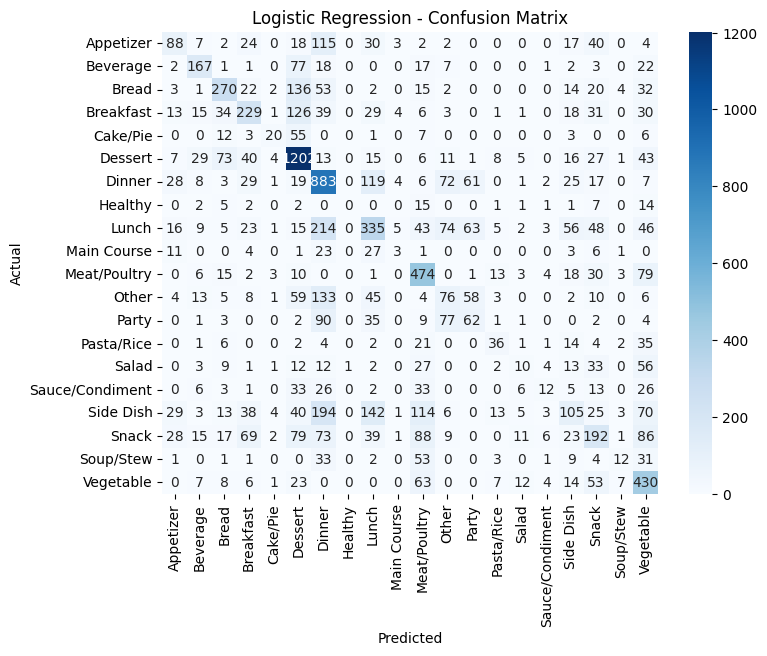


### Random Forest
### Train Accuracy: 100.0%
### Test Accuracy: 49.3%
                 precision    recall  f1-score   support

      Appetizer       0.39      0.09      0.14       352
       Beverage       0.71      0.61      0.66       318
          Bread       0.67      0.44      0.53       576
      Breakfast       0.61      0.32      0.42       580
       Cake/Pie       1.00      0.13      0.23       107
        Dessert       0.56      0.91      0.69      1501
         Dinner       0.44      0.70      0.54      1285
        Healthy       1.00      0.18      0.30        51
          Lunch       0.41      0.44      0.42       963
    Main Course       0.67      0.03      0.05        80
   Meat/Poultry       0.50      0.81      0.61       662
          Other       0.22      0.15      0.17       427
          Party       0.23      0.20      0.21       287
     Pasta/Rice       0.96      0.19      0.32       129
          Salad       0.95      0.11      0.20       186
Sauce/Condiment 

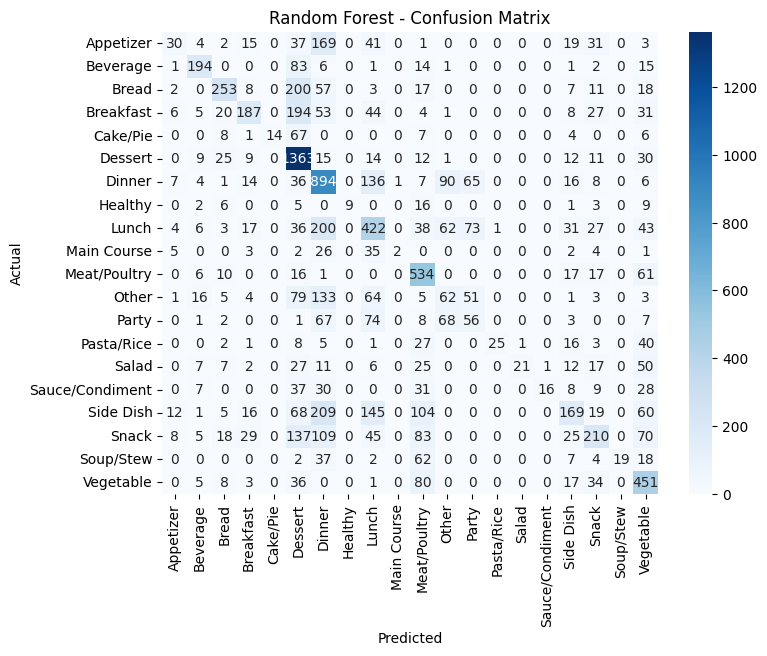


### SVM (Linear Kernel)
### Train Accuracy: 49.57%
### Test Accuracy: 46.53%
                 precision    recall  f1-score   support

      Appetizer       0.37      0.27      0.31       352
       Beverage       0.59      0.59      0.59       318
          Bread       0.58      0.46      0.51       576
      Breakfast       0.43      0.40      0.42       580
       Cake/Pie       0.50      0.16      0.24       107
        Dessert       0.63      0.80      0.70      1501
         Dinner       0.46      0.66      0.54      1285
        Healthy       0.00      0.00      0.00        51
          Lunch       0.40      0.39      0.39       963
    Main Course       0.50      0.01      0.02        80
   Meat/Poultry       0.48      0.71      0.57       662
          Other       0.22      0.27      0.24       427
          Party       0.26      0.15      0.19       287
     Pasta/Rice       0.37      0.24      0.29       129
          Salad       0.21      0.06      0.09       186
Sauce/Con

C:\Users\Gurupriya Vaikundam\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Gurupriya Vaikundam\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Gurupriya Vaikundam\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

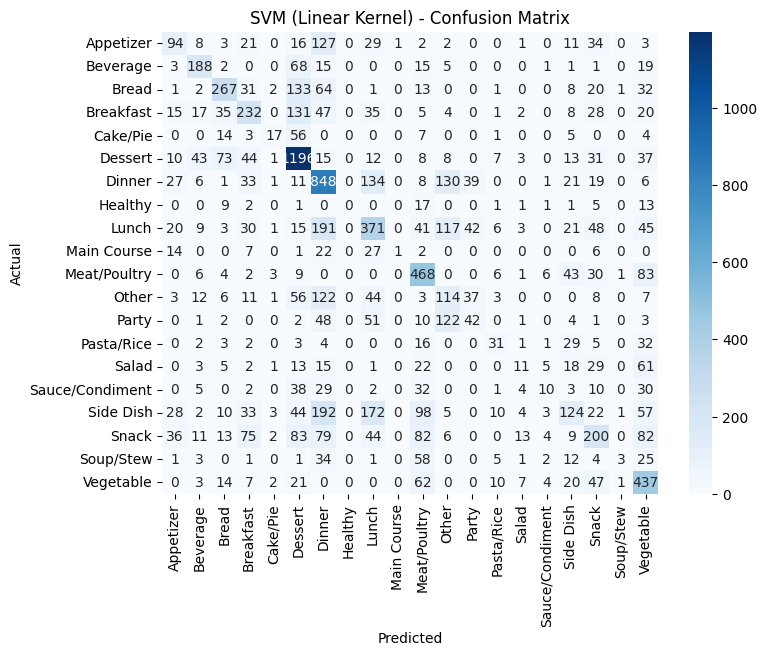


### Naive Bayes
### Train Accuracy: 14.17%
### Test Accuracy: 12.97%
                 precision    recall  f1-score   support

      Appetizer       0.09      0.01      0.02       352
       Beverage       0.04      0.11      0.06       318
          Bread       0.04      0.01      0.01       576
      Breakfast       0.25      0.01      0.02       580
       Cake/Pie       0.01      0.08      0.02       107
        Dessert       0.20      0.00      0.01      1501
         Dinner       0.17      0.00      0.00      1285
        Healthy       0.02      0.69      0.03        51
          Lunch       0.32      0.01      0.03       963
    Main Course       0.04      0.61      0.08        80
   Meat/Poultry       0.44      0.61      0.51       662
          Other       0.08      0.02      0.04       427
          Party       0.20      0.92      0.33       287
     Pasta/Rice       0.01      0.03      0.01       129
          Salad       0.05      0.01      0.02       186
Sauce/Condiment  

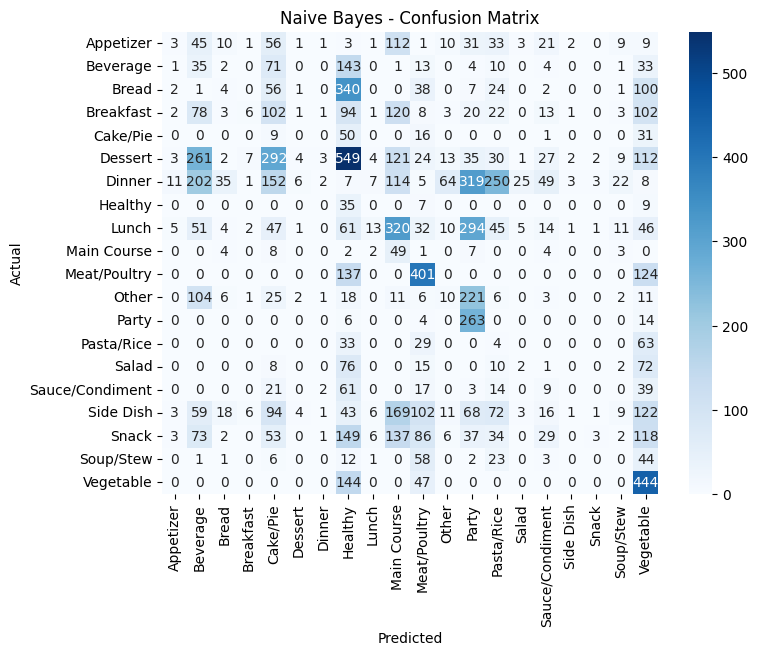


### KNN (k=5)
### Train Accuracy: 63.4%
### Test Accuracy: 46.17%
                 precision    recall  f1-score   support

      Appetizer       0.27      0.30      0.28       352
       Beverage       0.35      0.79      0.48       318
          Bread       0.45      0.57      0.51       576
      Breakfast       0.46      0.48      0.47       580
       Cake/Pie       0.36      0.28      0.32       107
        Dessert       0.69      0.71      0.70      1501
         Dinner       0.52      0.54      0.53      1285
        Healthy       0.14      0.10      0.11        51
          Lunch       0.37      0.40      0.38       963
    Main Course       0.23      0.06      0.10        80
   Meat/Poultry       0.54      0.65      0.59       662
          Other       0.22      0.20      0.21       427
          Party       0.22      0.13      0.16       287
     Pasta/Rice       0.47      0.27      0.34       129
          Salad       0.26      0.20      0.23       186
Sauce/Condiment     

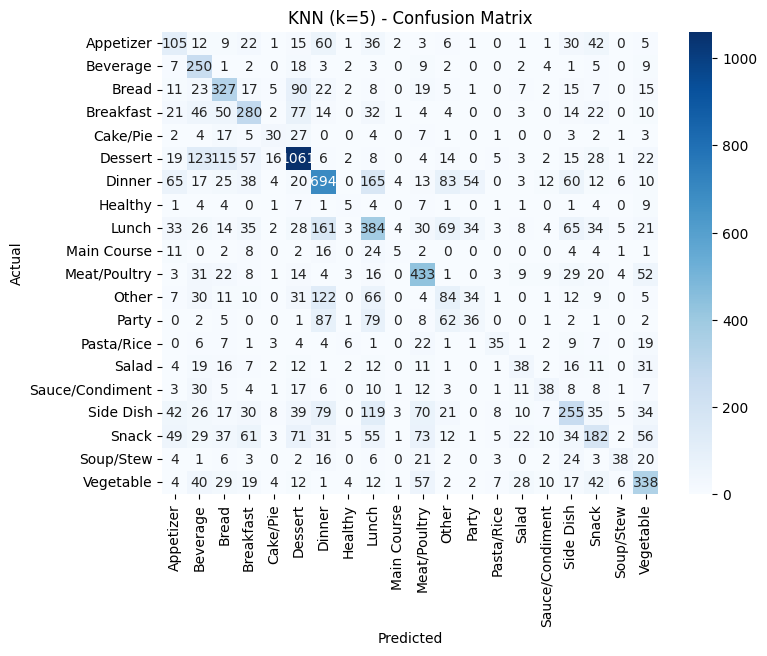

In [7]:
for name, model in models.items():
    print(f"\n### {name}")
    model.fit(X_train, y_train)

    train_acc = model.score(X_train, y_train)
    print(f"### Train Accuracy: {round(train_acc * 100, 2)}%")

    y_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)
    print(f"### Test Accuracy: {round(test_acc * 100, 2)}%")

    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


Save Models

In [ ]:
import joblib  
d2v_model.save("doc2vec_recipe.model")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(encoder, "region_encoder.pkl")

for name, model in models.items():
    print(f"\n### {name}")
    model.fit(X_train, y_train)
    filename = name.lower().replace(" ", "_").replace("(", "").replace(")", "") + ".pkl"
    joblib.dump(model, filename)
    print(f"### Saved model to {filename}")   